In [1]:
using Pkg
Pkg.DEFAULT_IO[] = stdout
Pkg.activate(".");
Pkg.status()

  Activating environment at `~/Research/Paramananigans.jl/Project.toml`
      Status `~/Research/Paramananigans.jl/Project.toml`
  [31c24e10] Distributions v0.24.18
  [aa8a2aa5] EnsembleKalmanProcesses v0.1.0 `https://github.com/CliMA/EnsembleKalmanProcesses.jl.git#main`
  [033835bb] JLD2 v0.4.13
  [9e8cae18] Oceananigans v0.62.0
  [91a5bcdd] Plots v1.20.1
  [b8865327] UnicodePlots v2.0.0


In [9]:
using Oceananigans
using Statistics
using Random
using Plots
using LinearAlgebra

In [3]:
function two_dimensional_turbulence(ν=1e-4; Nx=128, architecture=CPU(), advection=WENO5())
    Random.seed!(123)
    Lx = 2π

    model = NonhydrostaticModel(timestepper = :RungeKutta3,
                                architecture = architecture,
                                grid = RegularRectilinearGrid(size=(Nx, Nx), halo=(3, 3), extent=(Lx, Lx), topology=(Periodic, Periodic, Flat)),
                                advection = advection,
                                buoyancy = nothing,
                                tracers = nothing,
                                closure = IsotropicDiffusivity(ν=ν))

    u, v, w = model.velocities
    uᵢ = rand(size(u)...)
    vᵢ = rand(size(v)...)

    uᵢ .-= mean(uᵢ)
    vᵢ .-= mean(vᵢ)

    set!(model, u=uᵢ, v=vᵢ)

    progress(sim) = @info "(ν = $ν) iteration: $(sim.model.clock.iteration), time: $(round(Int, sim.model.clock.time))"

    simulation = Simulation(model, Δt=0.1, stop_time=30, iteration_interval=50, progress=progress)

    run!(simulation)

    return Array(interior(model.velocities.u))[:, :, 1]
end

two_dimensional_turbulence (generic function with 2 methods)

┌ Info: (ν = 0.0001) iteration: 50, time: 5
└ @ Main In[3]:22
┌ Info: (ν = 0.0001) iteration: 100, time: 10
└ @ Main In[3]:22
┌ Info: (ν = 0.0001) iteration: 150, time: 15
└ @ Main In[3]:22
┌ Info: (ν = 0.0001) iteration: 200, time: 20
└ @ Main In[3]:22
┌ Info: (ν = 0.0001) iteration: 250, time: 25
└ @ Main In[3]:22
┌ Info: (ν = 0.0001) iteration: 300, time: 30
└ @ Main In[3]:22
┌ Info: Simulation is stopping. Model time 30 seconds has hit or exceeded simulation stop time 30 seconds.
└ @ Oceananigans.Simulations /Users/navid/.julia/packages/Oceananigans/9o1xJ/src/Simulations/run.jl:42


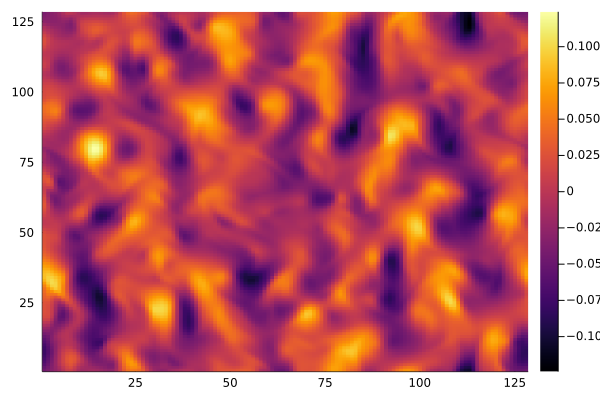

In [7]:
u_reference = two_dimensional_turbulence()

heatmap(u_reference)

In [18]:
viscosities = [1e-5, 2e-5, 4e-5, 6e-5, 7e-5, 8e-5, 9e-5, 9.5e-5, 1.02e-4, 1.1e-4, 1.2e-4, 1.5e-4, 2e-4, 3e-4, 5e-4, 8e-4, 1e-3]
errors = zeros(0)

for ν in viscosities
    u = two_dimensional_turbulence(ν)
    
    error = norm(u - u_reference) / norm(u_reference)
    
    push!(errors, error) 
end

┌ Info: (ν = 1.0e-5) iteration: 50, time: 5
└ @ Main In[3]:22
┌ Info: (ν = 1.0e-5) iteration: 100, time: 10
└ @ Main In[3]:22
┌ Info: (ν = 1.0e-5) iteration: 150, time: 15
└ @ Main In[3]:22
┌ Info: (ν = 1.0e-5) iteration: 200, time: 20
└ @ Main In[3]:22
┌ Info: (ν = 1.0e-5) iteration: 250, time: 25
└ @ Main In[3]:22
┌ Info: (ν = 1.0e-5) iteration: 300, time: 30
└ @ Main In[3]:22
┌ Info: Simulation is stopping. Model time 30 seconds has hit or exceeded simulation stop time 30 seconds.
└ @ Oceananigans.Simulations /Users/navid/.julia/packages/Oceananigans/9o1xJ/src/Simulations/run.jl:42
┌ Info: (ν = 2.0e-5) iteration: 50, time: 5
└ @ Main In[3]:22
┌ Info: (ν = 2.0e-5) iteration: 100, time: 10
└ @ Main In[3]:22
┌ Info: (ν = 2.0e-5) iteration: 150, time: 15
└ @ Main In[3]:22
┌ Info: (ν = 2.0e-5) iteration: 200, time: 20
└ @ Main In[3]:22
┌ Info: (ν = 2.0e-5) iteration: 250, time: 25
└ @ Main In[3]:22
┌ Info: (ν = 2.0e-5) iteration: 300, time: 30
└ @ Main In[3]:22
┌ Info: Simulation is stop

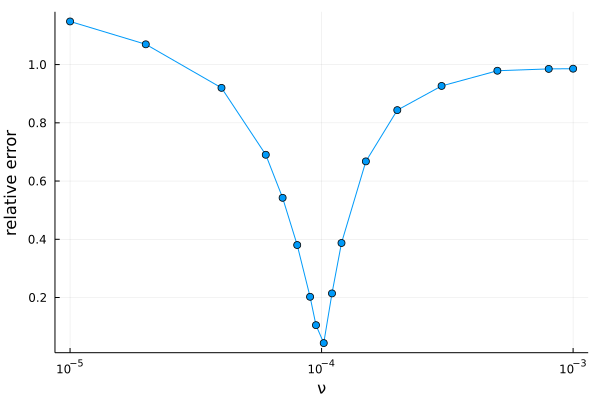

In [23]:
fig = plot(viscosities, errors,
           marker = :circle,
           xlabel = "ν",
           ylabel = "relative error",
           xscale = :log10,
           label = :none)